<a href="https://colab.research.google.com/github/jamieoliver/is-it-a-bird/blob/main/is-it-a-bird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Is it a Bird?

Based on https://github.com/fastai/course22/blob/master/00-is-it-a-bird-creating-a-model-from-your-own-data.ipynb.

In [1]:
!pip install -Uqq fastai duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 12.1 MB/s eta 0:00:00


## Download Datasets

In [2]:
from fastcore.all import *
from duckduckgo_search import *

def search_images(keyword, max_images=250):
  return L(DDGS().images(keyword, max_results=max_images)).itemgot('image')

In [3]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

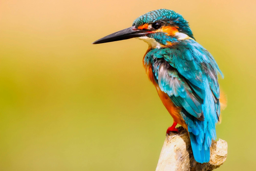

In [4]:
from fastdownload import *
from fastai.vision.all import *

dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

image = Image.open(dest)
image.to_thumb(256, 256)

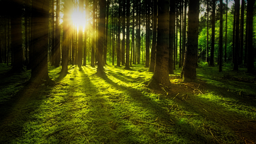

In [5]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

In [6]:
path = Path('bird-or-forest')
for category in 'bird','forest':
  dest = (path/category)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{category} photo'))
  resize_images(path/category, max_size=400, dest=path/category)

## Train Model

In [7]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

4

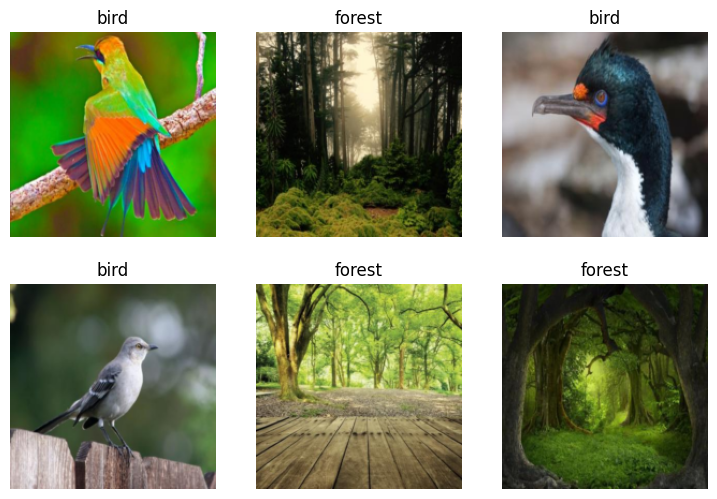

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

In [9]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 168MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.822400,0.070220,0.028571,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.194989,0.007971,0.000000,00:01
1,0.121748,0.013970,0.000000,00:01
2,0.087668,0.010668,0.000000,00:01


## Test Model

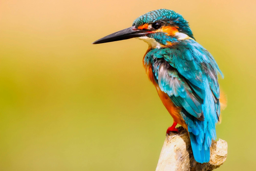

Image is a bird with probability 0.99


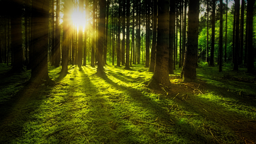

Image is a forest with probability 1.00


In [10]:
for filename in 'bird.jpg','forest.jpg':
  display(Image.open(filename).to_thumb(256, 256))
  pred,index,probs = learner.predict(PILImage.create(filename))
  print(f'Image is a {pred} with probability {probs[index]:.2f}')

## Export Model



In [11]:
learner.export('model.pkl')